In [1]:
import uproot
import pandas as pd
import mplhep as hep
import numpy as np
import awkward
import ROOT
import scipy.stats as stats #this one used to do fits
import matplotlib.pyplot as plt
import awkward as ak
import MyHelpers as mh
from tqdm import tqdm #this is a fancy feature to make a progress bar as the loop proceed


#to make the plots in CMS style execute this line
plt.style.use([hep.style.ROOT, hep.style.firamath])
plt.style.use(hep.style.CMS)

Welcome to JupyROOT 6.24/00


In [2]:
#Getting files
#Execute this line if running on SWAN, otherwise update the path to the data files:
PATH='/eos/cms/store/user/jjhollar/CERNSummerStudentProject2021/'
#PATH='data'
filename=PATH+'/gammagammaMuMu_FPMC_pT25_14TeV_PU200_NTUPLE_job1part1_version4.root'
#load the file content
tree = uproot.open(filename+":myana/mytree")
tree.show()

filename=PATH+'DYMuMu_PU200_NTUPLE_1_version3.root'
bg_tree = uproot.open(filename+":myana/mytree")

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
evt_size             | int32_t                  | AsDtype('>i4')
vtx_size             | int32_t                  | AsDtype('>i4')
vtx_x                | float[]                  | AsJagged(AsDtype('>f4'))
vtx_y                | float[]                  | AsJagged(AsDtype('>f4'))
vtx_z                | float[]                  | AsJagged(AsDtype('>f4'))
vtx_pt2              | float[]                  | AsJagged(AsDtype('>f4'))
vtx4D_size           | int32_t                  | AsDtype('>i4')
vtx4D_x              | float[]                  | AsJagged(AsDtype('>f4'))
vtx4D_y              | float[]                  | AsJagged(AsDtype('>f4'))
vtx4D_z              | float[]                  | AsJagged(AsDtype('>f4'))
vtx4D_t              | float[]                  | AsJagged(AsDtype('>f4'))
vtx4D_terr           | float[]             

In [3]:
#Create signal tree
event_info = tree.arrays(['genvtx_t0']) 
muons = tree.arrays(['pfcand_pt','pfcand_eta','pfcand_phi','pfcand_mass','pfcand_t','pfcand_vz'],'abs(pfcand_pid)==13') 
protons = tree.arrays(['genproton_xi','genproton_pz','genproton_vz','genproton_ispu']) 
vertices = tree.arrays(['vtx4D_t','vtx4D_z','vtx4D_pt2']) 

#Create background tree
#Compressing the muon data
bg_muons =[]
for batch, report in bg_tree.iterate(['pfcand_pt','pfcand_eta','pfcand_phi','pfcand_mass','pfcand_t','pfcand_vz','pfcand_pid'], step_size=1000, report=True):
    #print(report)
    bg_muons.append(batch[(abs(batch.pfcand_pid)==13) & (batch.pfcand_pt>25)] )
bg_muons=ak.concatenate(bg_muons)

bg_protons = bg_tree.arrays(['genproton_xi','genproton_pz','genproton_vz','genproton_ispu'],'(abs(genproton_pz)<6999) & (abs(genproton_pz)>0)')
bg_event_info = bg_tree.arrays(['genvtx_t0']) 
bg_vertices = bg_tree.arrays(['vtx4D_t','vtx4D_z','vtx4D_pt2'])

In [4]:
#define data array for signal
sig_data = {}
mh.InitData(sig_data)
#loop over all events for the signal
N = len(muons)
for i in tqdm(range(N)): 
    #find index of two highest pT muons with pT > 25 GeV
    mu=muons[i]
    mu1_idx, mu2_idx = mh.SelMu(mu)
    #if found less than 2 muons, skip the event:
    if mu1_idx<0 or mu2_idx<0: continue
    # find two signal protons:
    pr=protons[i]
    pr1_idx, pr2_idx = mh.SelProtons(pr)
    if pr1_idx<0 or pr2_idx<0: continue
    vx = vertices[i]
    ev = event_info[i]
    mh.Fill_mu(sig_data,mu,mu1_idx,mu2_idx)
    mh.Fill_pr(sig_data,pr,pr1_idx,pr2_idx,vx,ev)
sig = pd.DataFrame(data=sig_data)

#define data array for Background
bg_data = {}
mh.InitData(bg_data)
#loop over all events for the background
n = len(bg_muons)
for i in tqdm(range(n)): 
    #find index of two highest pT muons with pT > 25 GeV
    mu=bg_muons[i]
    mu1_idx, mu2_idx = mh.SelMu(mu)
    #if found less than 2 muons, skip the event:
    if mu1_idx<0 or mu2_idx<0: continue
    # find two signal protons:
    pr=bg_protons[i]
    pr1_idx, pr2_idx = mh.SelProtons(pr)
    #if pr1_idx<0 or pr2_idx<0: continue
    vx = bg_vertices[i]
    ev = bg_event_info[i]
    mh.Fill_mu(bg_data,mu,mu1_idx,mu2_idx)
    mh.Fill_pr(bg_data,pr,pr1_idx,pr2_idx,vx,ev)
bg = pd.DataFrame(data=bg_data)


100%|██████████| 15296/15296 [00:38<00:00, 400.16it/s]


89


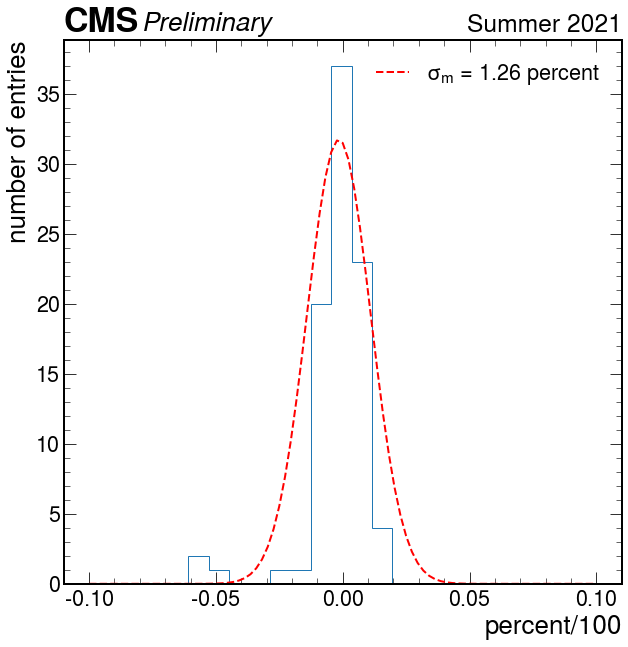

In [133]:
#You can plot mpp/mll-1 distribution, fit a gaussian and define a cut to be within the 2 sigma: |mpp-mll| < 2*sigma*mll
data = (sig['mpp'].values/sig['mll'].values)-1
data = data[~np.isnan(data) & (data < 0.20)]

#np.delete(data,max(data))
#data = data
print((len(data)))
bins = np.linspace(-0.1,0.1,89)
f, ax = plt.subplots()
plt.hist(data, histtype='step')

#fit to gaussian (to avoid bias from outliers restrict the fitted area):  = analysis['s_mpp']-analysis['s_mll'] <
(mu_m, sigma_m) = stats.norm.fit(data)
x=bins
y=stats.norm.pdf(x, mu_m, sigma_m)
ax.plot(x, y, 'r--', linewidth=2,label='$\sigma_{m}$ = %2.2f percent'%(sigma_m*100))

hep.cms.label(llabel="Preliminary", rlabel="Summer 2021", ax=ax)
ax.set(xlabel='percent/100', ylabel='number of entries')

ax.legend()
#plt.savefig('W5/fit_mass_ratio.png')

88


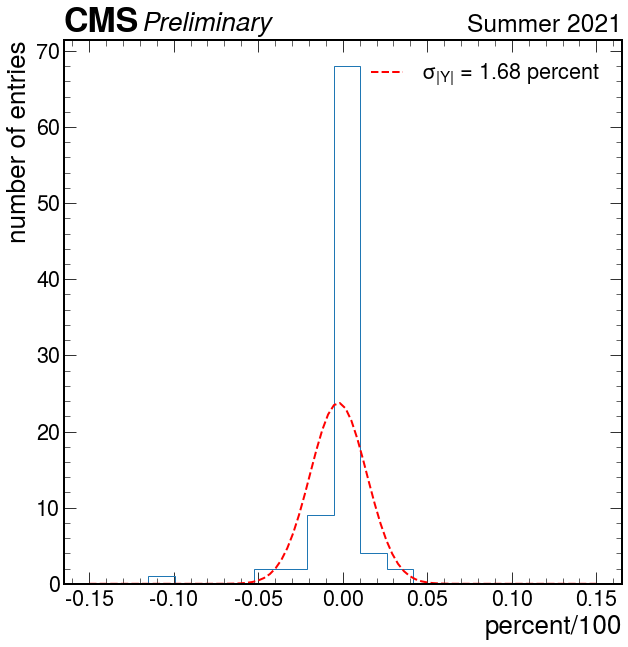

In [137]:
data = (sig['ypp'].values/sig['yll'].values) - 1

data = data[~np.isnan(data) & (data < 0.6) & (data > -0.6) ]

new_data = np.delete(data, np.where(data == np.max(data)) )
new_data = np.delete(new_data,np.where(data == np.min(data)) )
print(len(new_data))

bins = np.linspace(-0.15,0.15,88)
f, ax = plt.subplots()
plt.hist(new_data, histtype='step')

#fit to gaussian (to avoid bias from outliers restrict the fitted area):  = analysis['s_mpp']-analysis['s_mll'] <
(mu_y, sigma_y) = stats.norm.fit(new_data)
x=bins
y=stats.norm.pdf(x, mu_y, sigma_y)
ax.plot(x, y, 'r--', linewidth=2,label='$\sigma_{|Y|}$ = %2.2f percent'%(sigma_y*100))

hep.cms.label(llabel="Preliminary", rlabel="Summer 2021", ax=ax)
ax.set(xlabel='percent/100', ylabel='number of entries')

ax.legend()
#plt.savefig('W5/fit_eta_ratio.png')

In [138]:
#criteria for selection: |mpp-mll|<2sigma*mll
#sigma_m = 0.03
b = []
data = abs(bg['mpp']-bg['mll']) 

for i in range(0,len(data)):
    if data[i] < abs(2*sigma_m*bg['mll'][i]):
        b = np.append(b,bg['mpp'][i])
#print(len(b))
m_acc_bg = len(b)/len(data)
print('acceptance rate from background mass:')
print(m_acc_bg)

s = []
data = abs(sig['mpp'] - sig['mll'])
#print(data)
#print(2*sigma_m*analysis['s_mll'])
#print(data)
for i in range(0,len(data)):
    if data[i] < abs(2*sigma_m*sig['mll'][i]):
        s = np.append(s, sig['mpp'][i])

m_acc_s = len(s)/len(data)
print('acceptance rate from signal mass:')
print(m_acc_s)

acceptance rate from background mass:
0.000145032632342277
acceptance rate from signal mass:
0.9139784946236559


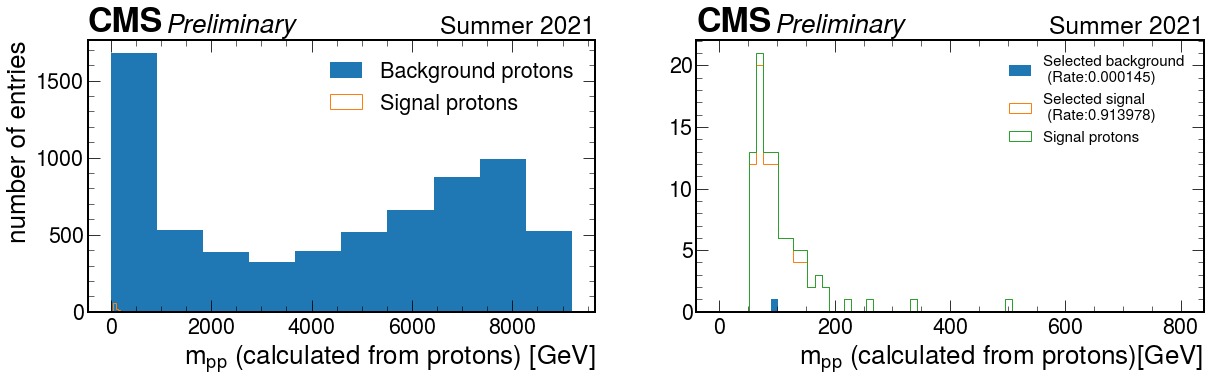

In [139]:

#plt.savefig('Correct/muon_eta.png',bbox_inches='tight')
f, ax = plt.subplots(1,2,figsize=(20,5),sharey=False)
#bins = np.linspace(0,3500,80)
ax[0].hist(bg['mpp'],label='Background protons')
ax[0].hist(sig['mpp'],histtype='step', label='Signal protons')
ax[0].set(xlabel=r'$m_{pp}$ (calculated from protons) [GeV]', ylabel='number of entries')
ax[0].legend()
bins = np.linspace(0,800,64)
ax[1].hist(b, bins,label='Selected background \n (Rate:%6.6f)'%m_acc_bg)
ax[1].hist(s, bins,histtype='step',label='Selected signal \n (Rate:%6.6f)'%m_acc_s)
ax[1].hist(sig['mpp'],bins,histtype='step',label='Signal protons')
ax[1].set(xlabel=r'$m_{pp}$ (calculated from protons)[GeV]')
ax[1].legend(fontsize=15)
for i in range(2):
    hep.cms.label(llabel="Preliminary", rlabel="Summer 2021", ax=ax[i])
    #ax[i].legend()
plt.savefig('W5/surviving_protons_mass',bbox_inches='tight')

In [140]:
#criteria for selection: |ypp-yll|<2sigma*mll
b = []
data = abs(bg['ypp']-bg['yll'])

for i in range(0,len(data)):
    if data[i] < abs(2*sigma_y*bg['yll'][i]): #the abs has no impact for the background !
        b = np.append(b,bg['ypp'][i])
#print(len(b))
y_acc_bg = len(b)/len(data)
print('acceptance rate from background eta:')
print(y_acc_bg)

s = []
#print(len(analysis['s_yll']))
data = abs(sig['ypp'] - sig['yll'])
for i in range(0,len(data)):
    if data[i] < abs(2*sigma_y*sig['yll'][i]): #but if I leave it out here, I have 0 for the signal acceptance!
        s = np.append(s, sig['ypp'][i])
#print(len(s))
y_acc_s = len(s)/len(data)
print('acceptance rate from signal eta:')
print(y_acc_s)

acceptance rate from background eta:
0.006236403190717912
acceptance rate from signal eta:
0.9032258064516129


6895
84
43


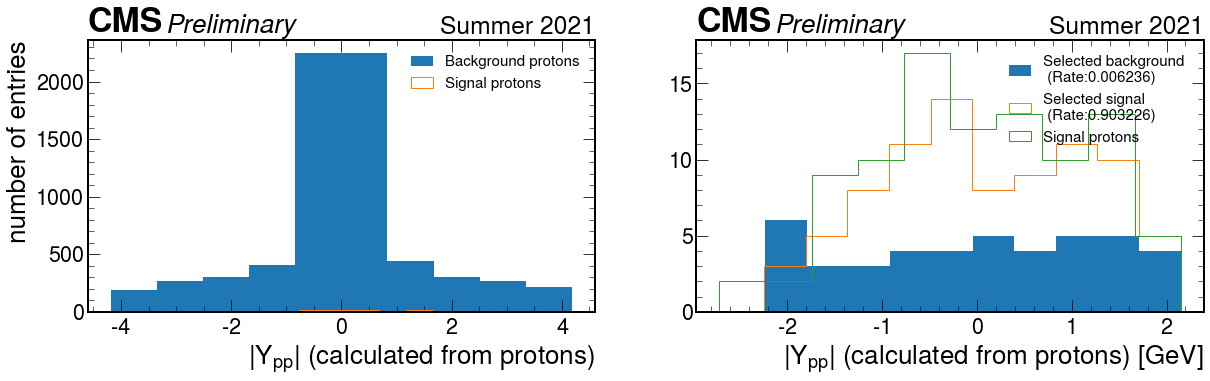

In [141]:

f, ax = plt.subplots(1,2,figsize=(20,5),sharey=False)
bins = np.linspace(-4,4,10)
print(len(bg['ypp']))
ax[0].hist(bg['ypp'],label='Background protons')
ax[0].hist(sig['ypp'], histtype='step', label='Signal protons')
ax[0].set(xlabel=r'$|Y_{pp}|$ (calculated from protons)', ylabel='number of entries')
binsb = np.linspace(-3,3,10)
print(len(s))
print(len(b))
ax[1].hist(b,label='Selected background \n (Rate:%6.6f)'%y_acc_bg)
ax[1].hist(s,histtype='step',label='Selected signal \n (Rate:%6.6f)'%y_acc_s)
ax[1].hist(sig['ypp'], histtype='step', label='Signal protons')
ax[1].set(xlabel=r'$|Y_{pp}|$ (calculated from protons) [GeV]')

for i in range(2):
    hep.cms.label(llabel="Preliminary", rlabel="Summer 2021", ax=ax[i])
    ax[i].legend(fontsize=15)
plt.savefig('W5/surviving_protons_eta', bbox_inches='tight')

In [142]:
data_mb = abs(bg['mpp']-bg['mll']) 
data_yb = abs(bg['ypp']-bg['yll'])

b_m = []
b_y = []
for i in range(0,len(data_mb)):
    if data_yb[i] < abs(2*sigma_y*bg['yll'][i]):
        if data_mb[i] < abs(2*sigma_m*bg['mll'][i]):
            b_m = np.append(b_m,bg['mpp'][i])
            b_y = np.append(b_y, bg['ypp'][i])
acc_bg = len(b_m)/len(data_yb)
print('acceptance rate from combined background cut:')
print(acc_bg)
s_m = []
s_y = []
data_ms = abs(sig['mpp'] - sig['mll'])
data_ys = abs(sig['ypp'] - sig['yll'])
for i in range(0,len(data)):
    if data_ys[i] < abs(2*sigma_y*sig['yll'][i]):
        if data_ms[i] < abs(2*sigma_m*sig['mll'][i]):        
            s_m = np.append(s_m, sig['mpp'][i])
            s_y = np.append(s_y, sig['ypp'][i])
acc_sig =len(s_m)/len(data_ms)
print('acceptance rate from combined signal cut:')
print(acc_sig)

acceptance rate from combined background cut:
0.0
acceptance rate from combined signal cut:
0.8602150537634409


6895


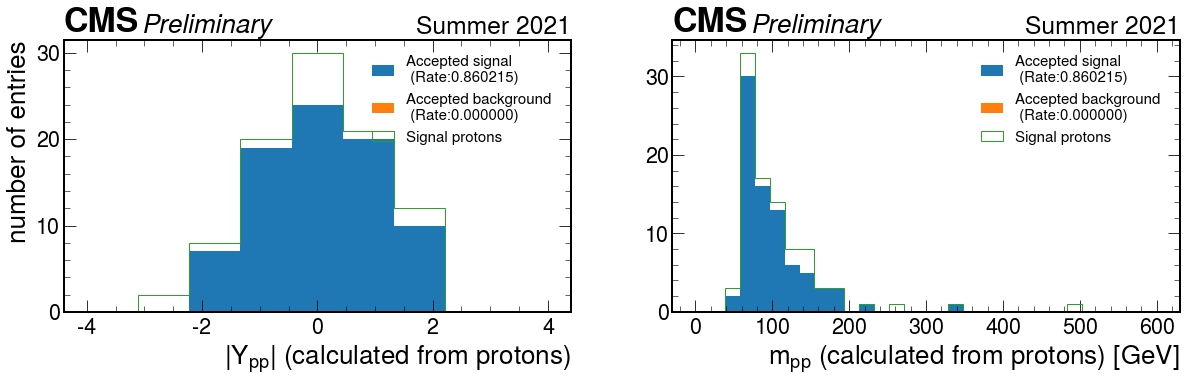

In [143]:
f, ax = plt.subplots(1,2,figsize=(20,5),sharey=False)
bins = np.linspace(-4,4,10)
print(len(bg['ypp']))
#ax[0].hist(bg_anal['ypp'],histtype='step',label='Background protons')
ax[0].hist(s_y,bins, label='Accepted signal \n (Rate:%6.6f)'%acc_sig)
ax[0].hist(b_y,bins, label='Accepted background \n (Rate:%6.6f)'%acc_bg)
ax[0].set(xlabel=r'$|Y_{pp}|$ (calculated from protons)', ylabel='number of entries')
ax[0].hist(sig['ypp'],bins, histtype='step', label='Signal protons')
bins = np.linspace(0,600,32)

#ax[1].hist(bg_anal['mpp'],histtype='step',label='Background protons')
ax[1].hist(s_m,bins, label='Accepted signal \n (Rate:%6.6f)'%acc_sig)
ax[1].hist(b_m,bins, label='Accepted background \n (Rate:%6.6f)'%acc_bg)
ax[1].hist(sig['mpp'],bins, histtype='step', label='Signal protons')
ax[1].set(xlabel=r'$m_{pp}$ (calculated from protons) [GeV]')

for i in range(2):
    hep.cms.label(llabel="Preliminary", rlabel="Summer 2021", ax=ax[i])
    ax[i].legend(fontsize=15)
plt.savefig('W5/surviving_protons', bbox_inches='tight')

In [ ]:
# And now we can finally re-write and correct the idea of timing correlation...nice

In [ ]:
#define genproton_t variable to work with. (this is the tp1 tp2 which will be later will be used). proton time is given by:
#genproton_t=genvtx_t0+(zpps+genproton_vz)/c where zpps=2e5  (200m)
#then we use the formula for Deltat to obtain the di-proton vertex, and then we compare it to vtx4D_z[0]
#for the signal it should agree, and for the background it should disagree. Here we will define a cut and complete step 2.

In [14]:
zpps = 2e5 #in cm
c = 3e10#in cm/s
#proton_t= sig['evt_t0'] + (np.average(sig['pr1_vz'].values + sig['pr2_vz'].values) + zpps)/3e19
#Confusion: Why do I get the same max and min for c = 3e8 and c = 3e19 ??
#print(max(proton_t))#We have ns..but why ? evt is in ns, vz is in cm zpps now too -> c in cm/ns: 3e8m/s -> 3e10 cm/s -> 3e19 cm/ns 
#
p1_t= sig['evt_t0'].values + ( sig['pr1_vz'].values + zpps)/c
p2_t= sig['evt_t0'].values + ( sig['pr2_vz'].values + zpps)/c


#pr_vz are equal in sign and magnitude ... something is off here

print(sig['pr2_vz'].values)
print(sig['pr1_vz'].values)
print(sig['evt_t0'])
print(p1_t - p2_t)
#1. vertex in space: z(muonsvtx) =  (t_p1 - t_p2)* c/2
#                     
#
#print(( sig['pr2_vz'].values + zpps))
mu_vz = (p1_t - p2_t)*c/2 #Actually * c !
print(mu_vz)
vz_4D = sig['pr_vtx_z']
#print(vz_4D)
#p1_t + p2_t = (2*zpps/c) + (sig['m1_t'] + sig['mu2_t'])/2 #plus or minus ??

[  0.831128     1.30256486   6.46120405   1.33102846  -4.70510006
   2.19353604  -7.61524296   4.24637842   2.6315279    2.45652318
   4.03264141  -1.90962446  -2.31680012   6.31387711  -2.95220399
  -1.38207901  -3.3657217    2.19955564   1.70250344   3.2047956
  -2.18746376   0.97952962  -1.13671303   0.39367738  -3.69123363
  -8.8502903   -4.0568552   -3.99575257   1.18198776  -3.49743319
   2.34442353  -3.40920091  -4.2754283   -1.48622215  -2.48876381
   0.16304834  -1.60778248  -0.84915066   1.79451358  -0.0944221
  -0.12980492   7.06905556  11.02346897  -1.22371924  -9.51971817
   5.5588212  -12.0124321   -7.89589119  -4.98104668   1.70977092
  -3.93614101  -0.67415053  -1.52660823   3.99191976  -2.93163061
   2.19936061  -0.97373664   1.54795933  -5.04115295  -1.15974092
  -1.07394755   2.79989576  -7.80066776  -1.66041625   5.59483004
   0.13547061  -4.33463812  -2.23050165   1.31719923  -1.56378353
   2.30651879   6.75062037   1.02598643  -0.65792751   3.42893553
   5.4078879

In [15]:
#Begin with timing cuts from PPS !
#From here rather useless tries - focus on selection  function then timing 
#1. vertex in space: z(muonsvtx) =  (t_p1 - t_p2)* c/2
#                            m      (1/2)*(3x10^8) (delta t_protons)
#                   -> muonvtx = pos_p1 + pos_p2

z_p2 = sig['pr2_vz'].values
z_p1 = sig['pr1_vz'].values

z_mu1 = sig['mu1_vz'].values
z_mu2 = sig['mu2_vz'].values

z_mu = (z_mu1 + z_mu2)/2
z_pp = (z_p2 + z_p1)/2 
c = 3e10
#define proton times from this
tp1 = 2*(z_mu + z_p2)/c
tp2 = 2*(z_mu - z_p1)/c

#print(z_pp)
#print(z_mu)

93
-0.03576618843992243


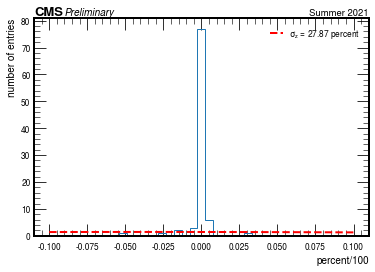

In [16]:
data = (z_pp - z_mu)/z_mu

print(len(data))
bins = np.linspace(-0.1,0.1,40)
f, ax = plt.subplots()
plt.hist(data, bins,histtype='step')

#fit to gaussian (to avoid bias from outliers restrict the fitted area):  = analysis['s_mpp']-analysis['s_mll'] <
(mu_z, sigma_z) = stats.norm.fit(data)
x=bins
y=stats.norm.pdf(x, mu_z, sigma_z)
ax.plot(x, y, 'r--', linewidth=2,label='$\sigma_{z}$ = %2.2f percent'%(sigma_z*100))
#print(2*sigma*analysis['s_mll'])

hep.cms.label(llabel="Preliminary", rlabel="Summer 2021", ax=ax)
ax.set(xlabel='percent/100', ylabel='number of entries')

print(mu_z)

ax.legend()
plt.savefig('W5/fit_vertex_pos.png')

In [269]:
z_p2 = bg_anal['pr2_vz'].values
z_p1 = bg_anal['pr1_vz'].values

z_mu1 = bg_anal['mu1_vz'].values
z_mu2 = bg_anal['mu2_vz'].values

b_z_mu = (z_mu1 + z_mu2)/2
b_z_pp = (z_p2 + z_p1)/2 

data_bz = abs(z_pp - z_mu)

b_z = []
for i in range(0,len(data_bz)):
    if data_bz[i] < abs(2*sigma_z*b_z_mu[i]):
            b_z = np.append(b_z,b_z_pp[i])
acc_bg = len(b_z)/len(data_bz)
print('acceptance rate from background cut:')
print(acc_bg)

z_p2 = analysis['s_pr2_vz'].values
z_p1 = analysis['s_pr1_vz'].values

z_mu1 = analysis['s_mu1_vz'].values
z_mu2 = analysis['s_mu2_vz'].values

z_mu = (z_mu1 + z_mu2)/2
z_pp = (z_p2 + z_p1)/2 

data_sz = abs(z_pp - z_mu)
s_z = []
for i in range(0,len(data_sz)):
    if data_sz[i] < abs(2*sigma_z*z_mu[i]):
            s_z = np.append(s_z, z_pp[i])
acc_sig =len(s_z)/len(data_sz)
print('acceptance rate from signal cut:')
print(acc_sig)

acceptance rate from background cut:
0.984375
acceptance rate from signal cut:
0.96875


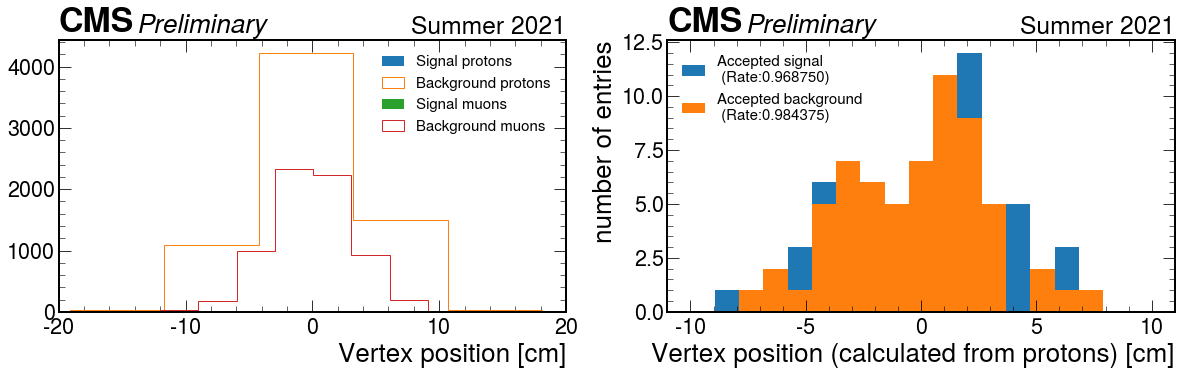

In [270]:
f, ax = plt.subplots(1,2,figsize=(20,5),sharey=False)

ax[0].hist(z_pp, label='Signal protons')
ax[0].hist(b_z_mu, histtype = 'step', label = 'Background protons')
ax[0].hist(z_mu, label='Signal muons')
ax[0].hist(b_z_pp, histtype = 'step', label = 'Background muons')
ax[0].set(xlabel=r'Vertex position [cm]')
ax[0].set_xlim(-20,20)
bins = np.linspace(-10,10,20)
ax[1].hist(s_z,bins, label='Accepted signal \n (Rate:%6.6f)'%acc_sig)
ax[1].hist(b_z, bins,label='Accepted background \n (Rate:%6.6f)'%acc_bg)
ax[1].set(xlabel=r'Vertex position (calculated from protons) [cm]', ylabel='number of entries')

for i in range(2):
    hep.cms.label(llabel="Preliminary", rlabel="Summer 2021", ax=ax[i])
    ax[i].legend(fontsize=15)
plt.savefig('W5/surviving_protons_vz', bbox_inches='tight')

In [271]:
#Super insecure about this one !
#Vertex position in time: (tp1 + tp2)*c = 2 zpps + t(mu)*c
#zpp = +-234m
mask_muon1_measured_time = (analysis['s_mu1_t']>-80) & (analysis['s_mu2_t']>-80)

masked_analysis=analysis[mask_muon1_measured_time]
tmu1 = masked_analysis['s_mu1_t'].values
tmu2 = masked_analysis['s_mu2_t'].values

z_p2 = masked_analysis['s_pr2_vz'].values
z_p1 = masked_analysis['s_pr1_vz'].values

z_mu1 = masked_analysis['s_mu1_vz'].values
z_mu2 = masked_analysis['s_mu2_vz'].values

true = masked_analysis['s_evt_t0']
z_mu = (z_mu1 + z_mu2)/2 #cm
z_pp = (z_p2 + z_p1)/2  #cm


#define proton time of arrival at pps in seconds !!!
# convert cm into m to convert to s to ns
tp1 = 2*(z_mu + z_p2)*1e-2*3e-8*1e9
tp2 = 2*(z_mu - z_p1)*1e-2*3e-8*1e9
#ns ?
tpp = true.values - (tp1+ tp2)
print(tpp)
# ns
tmu = (tmu1+tmu2)/2 
#tmu = masked_analysis['s_pr_vtx_t'].values
print((tmu))
#zpp in s and ns
zpp = 234*3e-10*1e9


[-3.28226969  0.67998635 -3.52866125  7.70459292  0.66255472  6.81067885
 -2.98769779  2.554532   -3.13110003  1.68059421 -7.45563057 -0.80387397
 -2.70424599  1.90932557 -4.97261945  6.64828712 -6.35764155 -7.68726258
 -4.66823975 -1.20706791 -1.88173463  5.69599707  9.31834617  3.36246541
 -5.20549939 -3.0620523  -2.79090385  2.42784057  3.218165    1.70674468
  4.01233433 -2.3159871  -2.39370809 -3.70197872  2.64765439 -1.62281855
  1.31138166 -0.25798775  4.06991696  4.913141    4.4903295  -1.43807929
  4.53163856 -3.1094055   3.85166403]
[-0.00514359 -0.26456782 -0.21522428  0.13947432  0.24600037  0.17796143
 -0.13686907 -0.10203473 -0.22394197  0.00650092 -0.09996813 -0.05867802
  0.32514502  0.04112998 -0.30345099 -0.24388307  0.13494338  0.0533144
  0.17405679  0.29825442 -0.30581111 -0.02060769  0.17631288  0.11051567
 -0.11912048  0.07946024  0.15703382 -0.01114387 -0.29293548  0.09021637
  0.00453095  0.30835395 -0.35236929  0.15593825  0.01067917 -0.38410352
 -0.11564501  

45
45
[9.92948614e-10 1.01129070e-07 6.18531868e-06 2.27187785e-04
 5.01123426e-03 6.63806135e-02 5.28049515e-01 2.52257952e+00
 7.23688899e+00 1.24679711e+01 1.28996074e+01 8.01482468e+00
 2.99053157e+00 6.70099951e-01 9.01711504e-02 7.28672642e-03
 3.53617824e-04 1.03055853e-05 1.80363230e-07 1.89565882e-09]


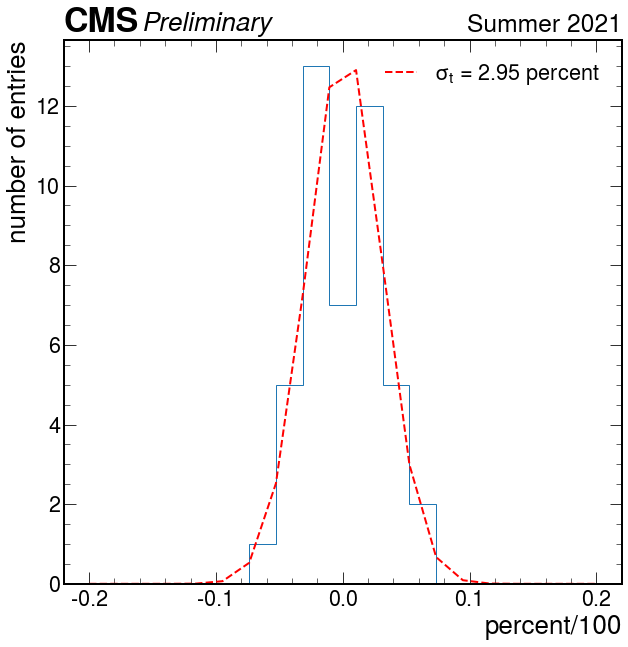

In [272]:
data = (tpp-tmu)/(2*zpp)
#print(data)
print(len(data))
#bins = np.linspace(-0.01,0.01,20)
#f, ax = plt.subplots()
#plt.hist(data, histtype='step')

#data = np.delete(data, np.where(data == np.min(data)))
#print(len(new_data))
#print(analysis['s_ypp'].values)
#print(analysis['s_yll'].values)
print(len(data))
bins = np.linspace(-0.2,0.2,20)
f, ax = plt.subplots()
plt.hist(data,bins, histtype='step')

#fit to gaussian (to avoid bias from outliers restrict the fitted area):  = analysis['s_mpp']-analysis['s_mll'] <
(mu_t, sigma_t) = stats.norm.fit(data)
x=bins
y=stats.norm.pdf(x, mu_t, sigma_t)
ax.plot(x, y, 'r--', linewidth=2,label='$\sigma_{t}$ = %2.2f percent'%(sigma_t*100))
#print(2*sigma*analysis['s_mll'])

hep.cms.label(llabel="Preliminary", rlabel="Summer 2021", ax=ax)
ax.set(xlabel='percent/100', ylabel='number of entries')

print(y)

ax.legend()
plt.savefig('W5/fit_vertex_t.png')

In [273]:
zpp = 234*3e-10*1e9
mask_measured_time = (bg_anal['mu1_t']>-80) & (bg_anal['mu2_t']>-80)

b_masked_analysis=bg_anal[mask_measured_time]
tmu1 = b_masked_analysis['mu1_t'].values
tmu2 = b_masked_analysis['mu2_t'].values

z_p2 = b_masked_analysis['pr2_vz'].values
z_p1 = b_masked_analysis['pr1_vz'].values

z_mu1 = b_masked_analysis['mu1_vz'].values
z_mu2 = b_masked_analysis['mu2_vz'].values

true = b_masked_analysis['evt_t0']

z_mu = (z_mu1 + z_mu2)/2 
z_pp = (z_p2 + z_p1)/2 

#define proton time of arrival at pps in ns !!!

tp1 = 2*(z_mu + z_p2)*1e-2*3e-8*1e9
tp2 = 2*(z_mu - z_p1)*1e-2*3e-8*1e9
#3e8 for c and 1e-9 for s to ns
b_tpp = true.values - (tp1+ tp2)
#3e8 for c and 1e-9 for ns
b_tmu = (tmu1+tmu2)/2 


data_bt = abs(b_tpp - b_tmu)

b_t = []
for i in range(0,len(data_bt)):
    if data_bt[i] < abs(2*sigma_t*2*zpp):
            b_t = np.append(b_m,b_tpp[i])
acc_bg = len(b_t)/len(data_bt)
print('acceptance rate from background cut:')
print(acc_bg)

mask_muon1_measured_time = (analysis['s_mu1_t']>-80) & (analysis['s_mu2_t']>-80)

masked_analysis=analysis[mask_muon1_measured_time]
tmu1 = masked_analysis['s_mu1_t'].values
tmu2 = masked_analysis['s_mu2_t'].values

z_p2 = masked_analysis['s_pr2_vz'].values
z_p1 = masked_analysis['s_pr1_vz'].values

z_mu1 = masked_analysis['s_mu1_vz'].values
z_mu2 = masked_analysis['s_mu2_vz'].values

true = masked_analysis['s_evt_t0']

z_mu = (z_mu1 + z_mu2)/2 
z_pp = (z_p2 + z_p1)/2 

#define proton time of arrival at pps in seconds !!!
tp1 = 2*(z_mu + z_p2)*1e-2*3e-8*1e9
tp2 = 2*(z_mu - z_p1)*1e-2*3e-8*1e9
#3e8 for c and 1e-9 for s to ns
s_tpp = true.values - (tp1 + tp2)
#3e8 for c and 1e-9 for ns
s_tmu = (tmu1+tmu2)/2 

data_st = abs(s_tpp - s_tmu)
s_t = []
for i in range(0,len(data_st)):
    if data_st[i] < abs(2*sigma_t*2*zpp):
            s_t = np.append(s_t, s_tpp[i])
acc_sig =len(s_t)/len(data_st)
print('acceptance rate from signal cut:')
print(acc_sig)

acceptance rate from background cut:
0.00021168501270110075
acceptance rate from signal cut:
0.9777777777777777


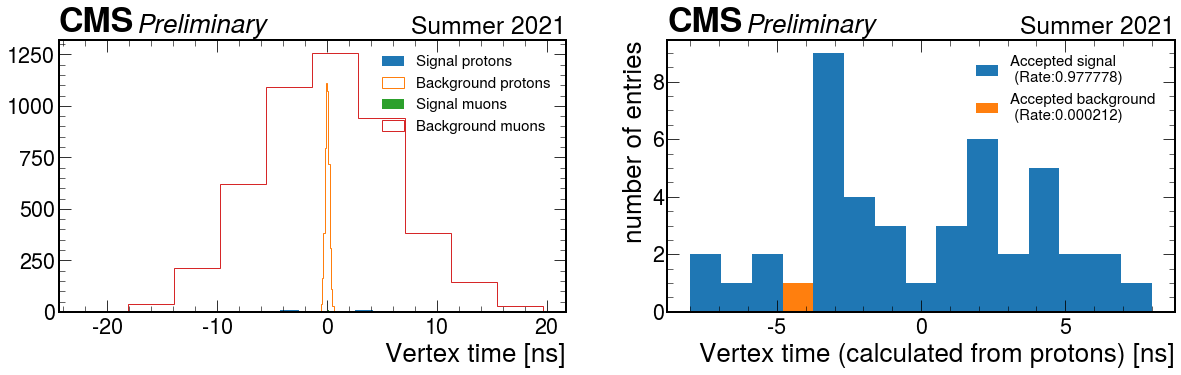

In [274]:
f, ax = plt.subplots(1,2,figsize=(20,5),sharey=False)
bins = np.linspace(-8,8,16)
ax[0].hist(s_tpp, label='Signal protons')
ax[0].hist(b_tmu, histtype = 'step', label = 'Background protons')
ax[0].hist(s_tmu, label='Signal muons')
ax[0].hist(b_tpp, histtype = 'step', label = 'Background muons')
ax[0].set(xlabel=r'Vertex time [ns]')
#ax[0].set_xlim(-20,20)

ax[1].hist(s_t, bins, label='Accepted signal \n (Rate:%6.6f)'%acc_sig)
ax[1].hist(b_t, bins, label='Accepted background \n (Rate:%6.6f)'%acc_bg)
ax[1].set(xlabel=r'Vertex time (calculated from protons) [ns]', ylabel='number of entries')

for i in range(2):
    hep.cms.label(llabel="Preliminary", rlabel="Summer 2021", ax=ax[i])
    ax[i].legend(fontsize=15)
plt.savefig('W5/surviving_protons_tvz', bbox_inches='tight')

In [281]:
#combined timing and spatial vertex cuts:
b_z = []
b_t = []
for i in range(0,len(data_bz)):
    if data_bz[i] < abs(2*sigma_z*b_z_mu[i]):
        if data_bt[i] < abs(2*sigma_t*2*zpp):
                b_z = np.append(b_z,b_z_pp[i])
                b_t = np.append(b_t,b_tpp[i])
acc_bg = len(b_z)/len(data_bz)
print('acceptance rate from background cut:')
print(acc_bg)

s_z = []
s_t = []
for i in range(0,len(z_mu)):
    if data_sz[i] < abs(2*sigma_z*z_mu[i]):
        if data_st[i] < abs(2*sigma_t*2*zpp):
                s_z = np.append(s_z, z_pp[i])
                s_t = np.append(s_t, s_tpp[i])
acc_sig =len(s_z)/len(z_mu)
print('acceptance rate from signal cut:')
print(acc_sig)

64
6895
acceptance rate from background cut:
0.796875
64
45
acceptance rate from signal cut:
0.9555555555555556


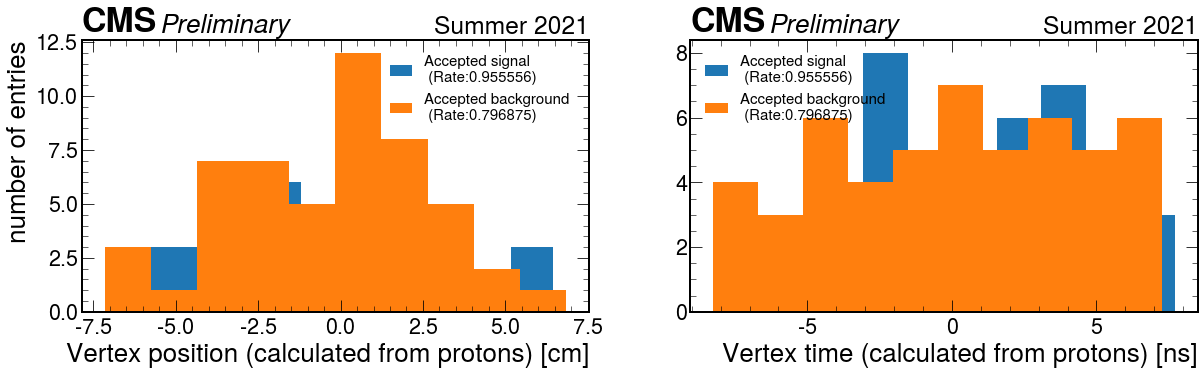

In [283]:
f, ax = plt.subplots(1,2,figsize=(20,5),sharey=False)
#bins = np.linspace(-4,4,10)
ax[0].hist(s_z, label='Accepted signal \n (Rate:%6.6f)'%acc_sig)
ax[0].hist(b_z, label='Accepted background \n (Rate:%6.6f)'%acc_bg)
ax[0].set(xlabel=r'Vertex position (calculated from protons) [cm]', ylabel='number of entries')
bins = np.linspace(0,600,32)

#ax[1].hist(bg_anal['mpp'],histtype='step',label='Background protons')
ax[1].hist(s_t,label='Accepted signal \n (Rate:%6.6f)'%acc_sig)
ax[1].hist(b_t, label='Accepted background \n (Rate:%6.6f)'%acc_bg)
ax[1].set(xlabel=r'Vertex time (calculated from protons) [ns]')

for i in range(2):
    hep.cms.label(llabel="Preliminary", rlabel="Summer 2021", ax=ax[i])
    ax[i].legend(fontsize=15)
plt.savefig('W5/surviving_protons', bbox_inches='tight')

In [174]:
#________________________________________________________________________________________For the ultimate goal !
#def GetSignalProtons(all_pairs):
#   DO SOME MAGIC -----------------------------needs to return the 2 indices from signal protons
y_data = abs(all_pairs['ypp']-all_pairs['yll'])
m_data = abs(all_pairs['mpp']-all_pairs['mll'])

selected = []

if (y_data[i] < abs(2*all_pairs*all_pairs['ypp'][i])) & (m_data[i] < abs(2*sigma_m*all_pairs['mll'][i])):
    selected[i] = all_pairs['something'][i]
    
print('number of selected proton pairs:')
print(len(selected))

print('acceptance rate:')
print(len(selected/all_pairs))

#and apply it on all proton pairs:
#proton_pos_idx=np.where(ak.to_numpy((pr.genproton_pz<0) & (pr.genproton_pz>-6999) ))[0]
#proton_neg_idx=np.where(ak.to_numpy((pr.genproton_pz>0) & (pr.genproton_pz< 6999) ))[0]
#create list of all possible pair combinations between list 1 and list 2:
#proton_pairs_idx=np.array(np.meshgrid(proton_pos_idx,proton_neg_idx)).T.reshape(-1,2)  #T.reshape: reshapes it into two a two-column array & meshgrid: returns coordinate matrices from coordinate vectors.
#pick up signal protons:
#pr1_idx,pr2_idx = GetSignalProtons(proton_pairs_idx)

NameError: name 'all_pairs' is not defined

In [ ]:
N = len(bg_muons)
print(N)
N_muons = []
for i in range(N):
    N_muons.append(len(bg_muons.pfcand_pt[i]))
    
#lets draw hisgorgam of number of muons:
f, ax = plt.subplots(figsize=(10,5))
plt.hist(N_muons, bins=np.linspace(0,3.5,40),label='Background muons')
hep.cms.label(llabel="Preliminary", rlabel="Summer 2021", ax=ax)
ax.legend(); 
ax.set(xlabel='Number of muons in event', ylabel='number of entries')
#plt.savefig('AnalyseW2/Bg_number_muons_signal.png',bbox_inches='tight')

In [ ]:
N = len(bg_protons)
print(N)
N_protons = []
for i in range(N):
    N_protons.append(len(bg_protons.genproton_pz[i]))
    
#lets draw hisgorgam of number of muons:
f, ax = plt.subplots(figsize=(10,5))
plt.hist(N_protons, label='Background protons')
hep.cms.label(llabel="Preliminary", rlabel="Summer 2021", ax=ax)
ax.legend(); 
ax.set(xlabel='Number of protons in event', ylabel='number of entries')
#plt.savefig('W5/Bg_number_protons_all.png',bbox_inches='tight')

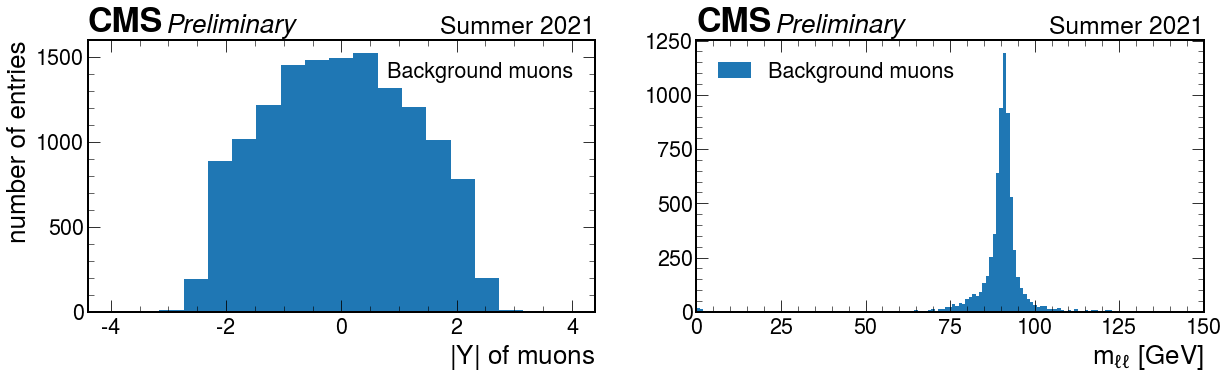

In [414]:
#print(bg_anal['mpp'].values)
f, ax = plt.subplots(1,2,figsize=(20,5),sharey=False)
ax[0].hist(np.concatenate([bg_anal['mu1_eta'].values,bg_anal['mu2_eta'].values]),bins=np.linspace(-4,4,20), label='Background muons')
ax[0].set(xlabel=r'$|Y|$ of muons', ylabel='number of entries')
#ax[0].set_ylim(0,1200)

ax[1].hist(bg_anal['mll'].values, bins=np.linspace(0,150,150),label='Background muons')
ax[1].set(xlabel=r'$m_{\ell\ell}$ [GeV]')
ax[1].set_xlim(0,150)
for i in range(2):
    hep.cms.label(llabel="Preliminary", rlabel="Summer 2021", ax=ax[i])
    ax[i].legend()
#plt.savefig('AnalyseW2/bg_dimuon_analysis_corrected.png',bbox_inches='tight')

In [ ]:
#plot mpp vs mll for pile-up and signal pairs.

fig, axes = plt.subplots(1,2,figsize=(18,10) )
proton = analysis['s_mpp'].values
muon = analysis['s_mll'].values

b_proton = bg_anal['mpp'].values
b_muon = bg_anal['mll'].values

print(len(b_muon))
print(len(muon))

h = axes[0].hist2d(proton, muon, bins=(32,32) , cmap='viridis')
axes[0].set(xlabel=r'signal $m_{pp}$ [GeV]', ylabel=r'signal $m_{\ell \ell}$ [GeV]')
#axes[0].set_ylim(50,500)
#axes[0].set_xlim(50,500)
axes[1].hist2d(b_proton, b_muon, bins=(32,32) , cmap='viridis')
axes[1].set(xlabel=r'background $m_{pp}$ [GeV]', ylabel=r'background $m_{\ell \ell}$ [GeV]')
axes[1].set_ylim(0,700)
fig.colorbar(h[3], ax=axes)
#plt.ylim(0,250)
for i in range(2): hep.cms.label(llabel="Preliminary", rlabel="Summer 2021", ax=axes[i])

#plt.savefig('AnalyseW2/corr_mpp_mll_sig_bg')

In [ ]:
#plot mpp vs mll for pile-up and signal pairs.

fig, axes = plt.subplots(1,2,figsize=(18,10) )
proton = analysis['s_mpp'].values
muon = analysis['s_mll'].values

b_proton = bg_anal['mpp'].values
b_muon = bg_anal['mll'].values

print(len(b_muon))
print(len(muon))
m = []
for i in range(0,64):
    m = np.append(m,b_muon[i])
print(len(m))
h = axes[0].hist2d(proton, muon, bins=(32,32) , cmap='viridis')
axes[0].set(xlabel=r'signal $m_{pp}$ [GeV]', ylabel=r'signal $m_{\ell \ell}$ [GeV]')
#axes[0].set_ylim(50,500)
#axes[0].set_xlim(50,500)
axes[1].hist2d(muon, m, bins=(32,32) , cmap='viridis')
axes[1].set(xlabel=r'signal $m_{\ell \ell}$ [GeV]', ylabel=r'background $m_{\ell \ell}$ [GeV]')
#axes[1].set_ylim(0,200)
fig.colorbar(h[3], ax=axes)
#plt.ylim(0,250)
for i in range(2): hep.cms.label(llabel="Preliminary", rlabel="Summer 2021", ax=axes[i])

#plt.savefig('AnalyseW2/corr_mpp_mll_sig_bg_corre')